In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='paper')
import numpy as np
from util.plot import color_list,markertype_list,plot_cdf
from util.const import MTU, SIZE_BUCKET_LIST_OUTPUT
from util.func import decode_dict,calculate_percentiles,map_percentiles
from collections import defaultdict

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

P99_PERCENTILE_LIST = np.arange(1, 101, 1)
n_percentiles=len(P99_PERCENTILE_LIST)

BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
n_size_bucket_list_output=len(bin_size_list)+1

file2matrix = {
    '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
    '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
    '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
}
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
file2oversub = {
    'spec/cluster_1_to_1.json': '1-to-1',
    'spec/cluster_2_to_1.json': '2-to-1',
    'spec/cluster_4_to_1.json': '4-to-1',
}
root_dir_baseline="/data1/lichenni/m3/parsimon-eval/expts/fig_8/data"

In [3]:
shard_seed=2
mlsys_dir=f'mlsys_perflow'
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4

def create_record(mix,shard_seed=shard_seed):
    mix_id = mix['id']
    mix_dir = f'{root_dir_baseline}/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m_s{shard_seed}/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'{mix_dir}/{mlsys_dir}/elapsed.txt'))
    
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3-config/records_{shard_seed}.csv')
    
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m_s{shard_seed}/records.csv')
    
    # Create lookup dictionaries for faster access
    ns3_lookup = df_ns3.set_index('flow_id').to_dict('index')
    pmn_m_lookup = df_pmn_m.set_index('flow_id').to_dict('index')
    
    # Accuracy metrics
    flows_fg_info={}
    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/sldn_flowsim.txt'):
        flows_fg_info_tmp={}
        with open(f'{mix_dir}/{mlsys_dir}/{path_idx}/sldn_flowsim.txt', 'r') as file:
            lines = file.readlines()
            num_flows_fg=int(lines[0].strip())
            
            for line in lines[1:1+num_flows_fg]:
                data=line.strip().split(" ")
                flow_id=int(data[0])
                size_flowsim=float(data[1])
                sldn_flowsim=float(data[2])
                
                if flow_id in ns3_lookup and flow_id in pmn_m_lookup:
                    size_ns3 = float(ns3_lookup[flow_id]['size'])
                    size_pmn_m = float(pmn_m_lookup[flow_id]['size'])

                    assert size_ns3 == size_pmn_m == size_flowsim

                    sldn_ns3 = float(ns3_lookup[flow_id]['slowdown'])
                    sldn_pmn_m = float(pmn_m_lookup[flow_id]['slowdown'])

                    flows_fg_info_tmp[flow_id] = [size_flowsim, sldn_ns3, sldn_pmn_m, sldn_flowsim]
                      
        flows_fg_info[path_idx]=flows_fg_info_tmp
        print(f'{mix_id}-{path_idx}: {num_flows_fg}, {len(flows_fg_info_tmp)}')     
        path_idx+=1
    
    record = {
            'id': mix['id'],
            'matrix': file2matrix[mix['spatial']],
            'size_dist': file2dist[mix['size_dist']],
            'lognorm_sigma': mix['lognorm_sigma'],
            'max_load_spec': mix['max_load'],
            'max_load': max_load,
            'top10pct_load': top10pct_load,
            'oversub': file2oversub[mix['cluster']],
            'window': float(mix["window"]),
            'enable_pfc': float(mix["enable_pfc"]),
            'param_1': float(mix["param_1"]),
            "flows": flows_fg_info,
    }
    return record
    
def get_records():
    mix_file = f'{root_dir_baseline}/../spec/all_dctcp.mix.json'
    # mix_file = f'{root_dir_baseline}/../spec/0.mix.json'
    with open(mix_file) as f:
        mixes = json.load(f)
        
    records_list = []
    for mix in mixes:
        mix_id = mix["id"]
        npz_file = f'./data/perflow_mix_{mix_id}.npz'
        if os.path.exists(npz_file):
            with np.load(npz_file,allow_pickle=True) as data:
                record = data['arr_0'].item()
        else:
            record = create_record(mix)
            np.savez(npz_file, record)
        records_list.append(record)
    
    return records_list

records = get_records()

0: [37.64740208  8.1778797  29.51911172  8.56402752]


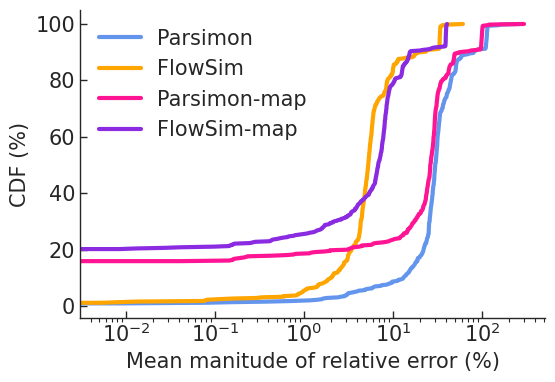

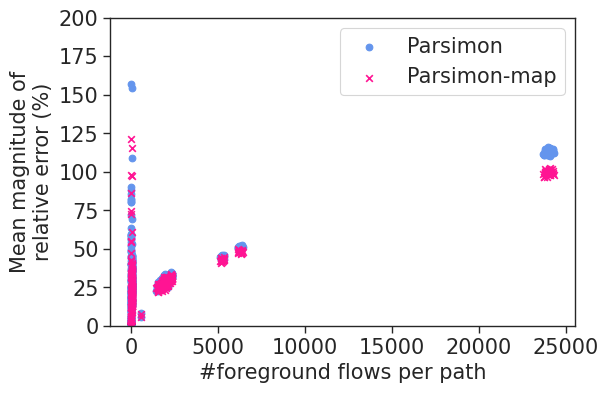

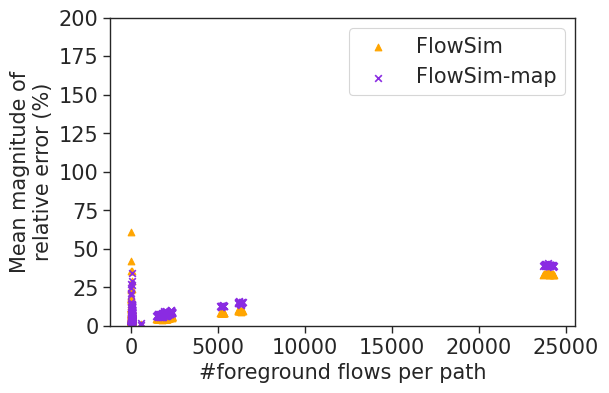

In [11]:
legend_list=['Parsimon','FlowSim','Parsimon-map','FlowSim-map']
fig_idx=0
for index, record in enumerate(records[:1]):
    res_error=[]
    res_num_flows=[]
    flows=record['flows']
    for path_idx, flows_fg_info in flows.items():
        # print(f'{record["id"]}-{path_idx}: {len(flows_fg_info)}')
        flows_fg_info=np.array(list(flows_fg_info.values()))
        
        res_num_flows.append(len(flows_fg_info))
        size=flows_fg_info[:,0]
        sldn_ns3=flows_fg_info[:,1]
        sldn_pmn_m=flows_fg_info[:,2]
        sldn_flowsim=flows_fg_info[:,3]
        assert len(size)==len(sldn_ns3)==len(sldn_pmn_m)==len(sldn_flowsim)
        
        
        bins=np.digitize(size,bin_size_list)
        
        flows_ns3=[]
        flows_pmn_m=[]
        flows_pmn_m_map=[]
        flows_flowsim=[]
        flows_flowsim_map=[]
    
        for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
            gt = np.extract(bins==i, sldn_ns3)
            gt_pmn = np.extract(bins==i, sldn_pmn_m)
            gt_flowsim = np.extract(bins==i, sldn_flowsim)
            
            if(len(gt)==0): continue
            
            flows_ns3.extend(gt)
            flows_pmn_m.extend(gt_pmn)
            flows_pmn_m_map.extend(map_percentiles(gt_pmn,gt))
            
            flows_flowsim.extend(gt_flowsim)
            flows_flowsim_map.extend(map_percentiles(gt_flowsim,gt))
        flows_ns3=np.array(flows_ns3)
        flows_pmn_m=np.array(flows_pmn_m)
        flows_pmn_m_map=np.array(flows_pmn_m_map)
        flows_flowsim=np.array(flows_flowsim)
        flows_flowsim_map=np.array(flows_flowsim_map)
       
        # sldn_pmn_m_est=map_percentiles(sldn_pmn_m,sldn_ns3)
        # sldn_flowsim_est=map_percentiles(sldn_flowsim,sldn_ns3)
        
        error_pmn_m=np.mean(np.abs(flows_pmn_m-flows_ns3)/flows_ns3)*100
        error_flowsim=np.mean(np.abs(flows_flowsim-flows_ns3)/flows_ns3)*100
        error_pmn_m_est=np.mean(np.abs(flows_pmn_m_map-flows_ns3)/flows_ns3)*100
        error_flowsim_est=np.mean(np.abs(flows_flowsim_map-flows_ns3)/flows_ns3)*100
        
        res_error.append([error_pmn_m,error_flowsim,error_pmn_m_est,error_flowsim_est])
    res_error=np.array(res_error).transpose()
    print(f'{record["id"]}: {np.mean(res_error,axis=1)}')
    
    plot_cdf(res_error,None,legend_list,'Mean manitude of relative error (%)',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
    
    figure, ax = plt.subplots(figsize=(6, 4))
    _fontsize=15
    for i in [0,2]:
        plt.scatter(res_num_flows,res_error[i],label=legend_list[i],marker=markertype_list[i],color=color_list[i])
    plt.legend(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xlabel('#foreground flows per path', fontsize=_fontsize)
    plt.ylabel('Mean magnitude of\nrelative error (%)', fontsize=_fontsize)
    plt.ylim(0,200)
    plt.show()

    fig_idx+=1
    
    figure, ax = plt.subplots(figsize=(6, 4))
    _fontsize=15
    for i in [1,3]:
        plt.scatter(res_num_flows,res_error[i],label=legend_list[i],marker=markertype_list[i],color=color_list[i])
    plt.legend(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xlabel('#foreground flows per path', fontsize=_fontsize)
    plt.ylabel('Mean magnitude of\nrelative error (%)', fontsize=_fontsize)
    plt.ylim(0,200)
    plt.show()

    fig_idx+=1

0: 1391491
1: 1391477
2: 1540565
3: 93167
4: 93086
5: 99227
6: 99876
7: 85777
8: 108397
9: 108992
10: 1419658
11: 1419601
12: 1419797
13: 98962
14: 1393432
15: 97917
16: 100331
17: 89443
18: 92999
19: 1391482
20: 108344
21: 1419632
22: 1419686
23: 1540389
24: 89837
25: 100165
26: 93550
27: 98839
28: 108007
29: 89640
30: 1540565
31: 1393404
32: 90047
33: 89017
34: 1391443
35: 98316
36: 108376
37: 1391504
38: 1419750
39: 98657
40: 1419615
41: 108018
42: 1419723
43: 1391534
44: 98275
45: 98648
46: 93448
47: 110383
48: 85093
49: 98150
50: 93497
51: 108358
52: 1391478
53: 1391526
54: 1391495
55: 109668
56: 93526
57: 89374
58: 93104
59: 99034
60: 98258
61: 98318
62: 99065
63: 89754
64: 100395
65: 86091
66: 85270
67: 1419680
68: 89671
69: 1391503
70: 107572
71: 100573
72: 98446
73: 85033
74: 89531
75: 97927
76: 107764
77: 85787
78: 109124
79: 1540290
80: 93119
81: 1419663
82: 93125
83: 1419732
84: 108439
85: 93447
86: 1540518
87: 1419711
88: 1419731
89: 85702
90: 93534
91: 1419728
92: 99817
9

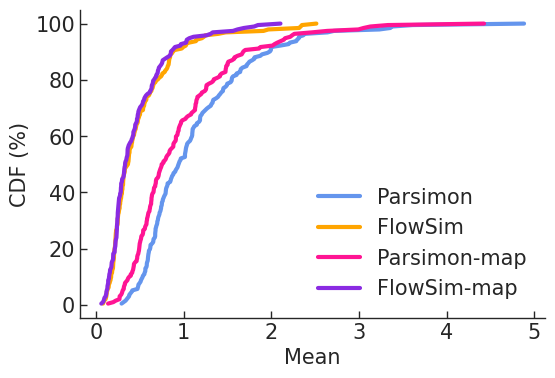

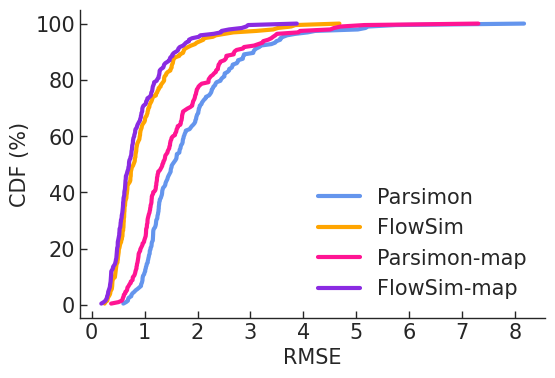

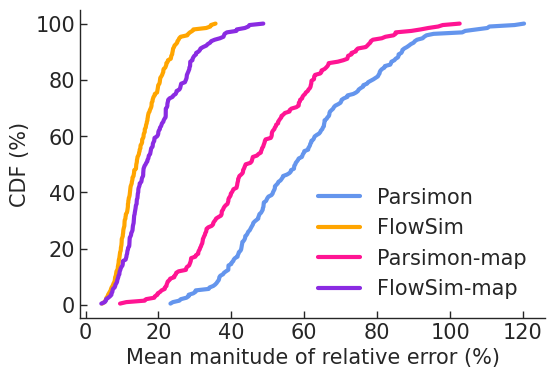

In [6]:
legend_list=['Parsimon','FlowSim','Parsimon-map','FlowSim-map']
fig_idx=0
res_error=np.zeros((len(records),4,3))
res_num_flows=[]
for mix_idx, record in enumerate(records):
    flows=record['flows']
    
    flows_ns3=[]
    
    flows_pmn_m=[]
    flows_pmn_m_map=[]
    
    flows_flowsim=[]
    flows_flowsim_map=[]
    
    for path_idx, flows_fg_info in flows.items():
        flows_fg_info=np.array(list(flows_fg_info.values()))
        if flows_fg_info.shape[0]==0:
            continue
        size=flows_fg_info[:,0]
        
        sldn_ns3=flows_fg_info[:,1]
        sldn_pmn_m=flows_fg_info[:,2]
        sldn_flowsim=flows_fg_info[:,3]
        bins=np.digitize(size,bin_size_list)
        
        for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
            gt = np.extract(bins==i, sldn_ns3)
            gt_pmn = np.extract(bins==i, sldn_pmn_m)
            gt_flowsim = np.extract(bins==i, sldn_flowsim)
            
            if(len(gt)==0): continue
            
            flows_ns3.extend(gt)
            flows_pmn_m.extend(gt_pmn)
            flows_pmn_m_map.extend(map_percentiles(gt_pmn,gt))
            
            flows_flowsim.extend(gt_flowsim)
            flows_flowsim_map.extend(map_percentiles(gt_flowsim,gt))
        # flows_ns3.extend(sldn_ns3)
        # flows_pmn_m.extend(sldn_pmn_m)
        # flows_pmn_m_map.extend(map_percentiles(sldn_pmn_m,sldn_ns3))
        
        # flows_flowsim.extend(sldn_flowsim)
        # flows_flowsim_map.extend(map_percentiles(sldn_flowsim,sldn_ns3))
        
    flows_ns3=np.array(flows_ns3)
    flows_pmn_m=np.array(flows_pmn_m)
    flows_pmn_m_map=np.array(flows_pmn_m_map)
    flows_flowsim=np.array(flows_flowsim)
    flows_flowsim_map=np.array(flows_flowsim_map)
    
    print(f'{record["id"]}: {len(flows_ns3)}')
    for tmp_idx,tmp in enumerate([flows_pmn_m,flows_flowsim,flows_pmn_m_map,flows_flowsim_map]):
        res_error[mix_idx,tmp_idx,0]=np.mean(np.abs(tmp - flows_ns3))
        res_error[mix_idx,tmp_idx,1]=np.sqrt(np.mean((tmp - flows_ns3) ** 2))
        res_error[mix_idx,tmp_idx,2]=np.mean(np.abs(tmp - flows_ns3)/flows_ns3)*100

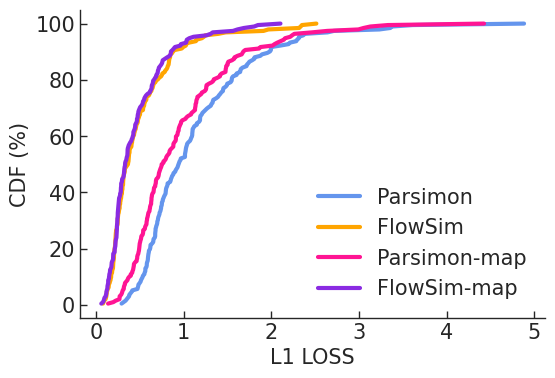

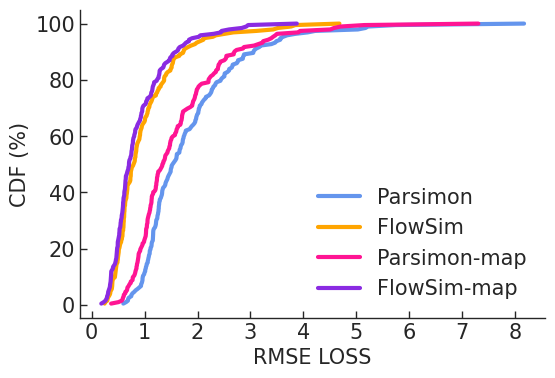

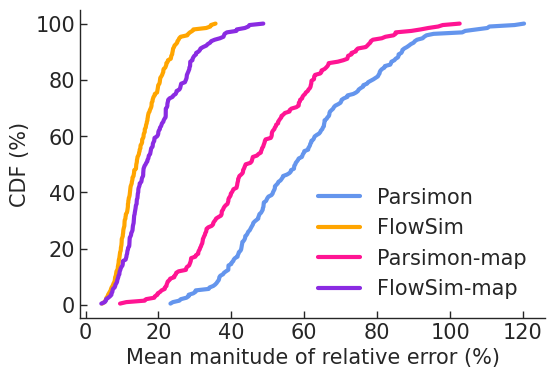

In [7]:
xlable_list=['L1 LOSS','RMSE LOSS','Mean manitude of relative error (%)']
for i in range(3):  
    plot_cdf(res_error[:,:,i].transpose(),None,legend_list,xlable_list[i],legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

In [6]:
shard_seed=2
mlsys_dir=f'mlsys_perflow'
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
def create_record(mix,shard_seed=shard_seed):
    mix_id = mix['id']
    mix_dir = f'{root_dir_baseline}/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m_s{shard_seed}/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'{mix_dir}/{mlsys_dir}/elapsed.txt'))
    
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3-config/records_{shard_seed}.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m_s{shard_seed}/records.csv')
    sizes=df_pmn_m['size']
    
    # Accuracy metrics
    df_mlsys = []
    df_mlsys_per_bucket = [[] for _ in range(n_size_bucket_list_output)]
    n_freq_list=[]
    n_flow_list=[]
    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
        with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
            lines = file.readlines()
            data=lines[0].strip().split(",")
            n_freq=int(data[-1])
            n_freq_list.append(n_freq)
            
            flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
            size_list=[sizes[flowid] for flowid in flowid_list]
            
            tmp=np.digitize(size_list, bin_size_list)
            # Count occurrences of each bin index
            bin_counts = np.zeros(n_size_bucket_list_output)
            for bin_idx in tmp:
                bin_counts[bin_idx]+=1
            n_flow_list.append(bin_counts)
        path_idx+=1
    
    n_flow_list=np.array(n_flow_list)
    n_flow_list_sum=n_flow_list.sum(axis=0)
    bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
    
    with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
        lines = file.readlines()
    lines = lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
            for _ in range(n_freq):
                df_mlsys_per_bucket[line_idx%n_size_bucket_list_output].extend(data)
        
    for i in range(len(df_mlsys_per_bucket)):
        n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
        df_mlsys.extend(np.random.choice(df_mlsys_per_bucket[i],n_tmp,replace=True))
    
    df_mlsys=pd.DataFrame(np.array(df_mlsys).flatten())
    
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0],len(df_mlsys[0]))
    
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__mlsys = p99_distance(df_ns3['slowdown'], df_mlsys[0])

    print(p99__ns3__pmn_m,p99__ns3__mlsys)
    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        'p99__ns3__mlsys': p99__ns3__mlsys,
        'window': float(mix["window"]),
        'enable_pfc': float(mix["enable_pfc"]),
        'param_1': float(mix["param_1"]),
    }
    return record
    
def get_records():
    mix_file = f'{root_dir_baseline}/../spec/all_dctcp.mix.json'
    csv_file = f'main_dctcp.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv(csv_file, index=False)
    return mixes

records = get_records()
print(records.shape)

0: len= 9999636 10000000 199997
0.10365850393043857 -0.12085002966619801
1: len= 9999636 10000000 199998
-0.0018975773068021567 -0.012978818752349587
2: len= 9999636 10000000 199998
0.037490255419744024 -0.027721257318041467
3: len= 9999796 10000000 199998
0.2675857521608118 -0.08244835207479465
4: len= 9999824 10000000 199998
0.0647215173866238 -0.04447346362851578
5: len= 9999842 10000000 199999
0.4196247809498581 -0.33129961616485204
6: len= 9999500 10000000 199999
0.20259588534505527 -0.005958415329526908
7: len= 9999842 10000000 199998
0.10339507436746354 0.14469453740462407
8: len= 9999824 10000000 199998
1.1889214380038817 0.03192235056382258
9: len= 9999630 10000000 199998
0.22970533755465708 -0.1418384610422695
10: len= 9999636 10000000 199998
-0.018646107435828004 -0.01933465971504281
11: len= 9999636 10000000 199999
0.01527826008675209 -0.0008988911493815519
12: len= 9999790 10000000 199999
0.16006379868444678 -0.12074061327983474
13: len= 9999842 10000000 199998
0.161442317

## Max load

### CDFs

mean: median: 9.910772761225997,18.292512354244057
 8.929184554449717,10.304335932461814
 90%: 20.67127367935006,41.83885771061764
 max: 33.129961616485204,145.99509631587642


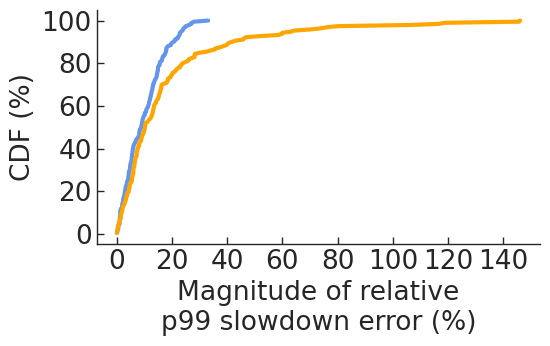

In [8]:
_fontsize=19
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records_abs
    data[each]*=100
    data['pct'] = data[each].rank(pct=True)*100
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['m3','Parsimon']
# XXX: This is a dirty hack. Look carefully at the labels!
# plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Magnitude of relative\np99 slowdown error (%)', fontsize=_fontsize)
plt.ylabel('CDF (%)', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf.pdf', bbox_inches='tight',pad_inches=0)
print(f"mean: median: {np.mean(records_abs['p99__ns3__mlsys'])},{np.mean(records_abs['p99__ns3__pmn_m'])}\n {np.median(records_abs['p99__ns3__mlsys'])},{np.median(records_abs['p99__ns3__pmn_m'])}\n 90%: {np.percentile(records_abs['p99__ns3__mlsys'], 90)},{np.percentile(records_abs['p99__ns3__pmn_m'], 90)}\n max: {np.max(records_abs['p99__ns3__mlsys'])},{np.max(records_abs['p99__ns3__pmn_m'])}")

0.7748544133669228
75.0


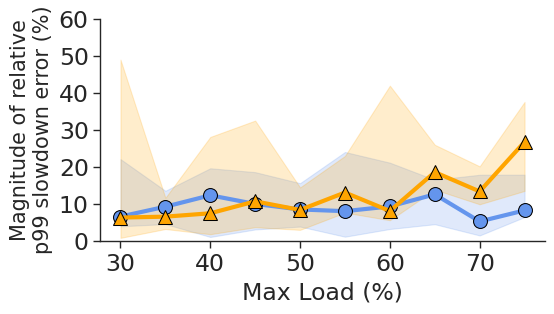

In [9]:
_fontsize=17
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])*100
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])*100

# records_abs.loc[records_abs['max_load'] < 0.3, 'max_load'] = 0.3
print(max(records_abs['max_load']))
records_abs['max_load']*=100
records_abs['max_load']=records_abs['max_load']//5*5
print(max(records_abs['max_load']))
records_abs=records_abs[records_abs['max_load']>=30]

records_abs=records_abs.sort_values(by='max_load')
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
labels=['m3','Parsimon']
for i,each in enumerate(column_list):
    # ax=sns.scatterplot(data = records_abs, x = 'max_load', y = each, color = color_list[i], ax=axs, marker=markertype_list[i], s=30)
    ax = sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar=("ci", 100), estimator='median', lw=3,markeredgecolor='black',markersize=10,legend=False)
    # ax=sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci=None, estimator='mean', lw=2)
    # sns.scatterplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=f'{each} Raw', s=30)
    
    # print(f"{each}: ",records_abs[each].min(),records_abs[each].max())
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()

# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.ylim(0,60)
# plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (%)',fontsize=_fontsize)
plt.ylabel('Magnitude of relative\np99 slowdown error (%)',fontsize=15)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)

plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

## Everything else (fix moderate load)

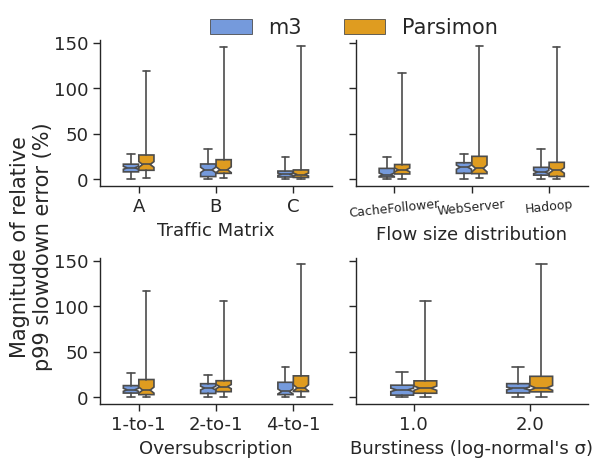

In [10]:

def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Traffic Matrix', ['A', 'B', 'C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal\'s σ)', [1.0, 2.0], 0),
    ]
    legend_loc_list=['upper left','upper left','upper left','upper left']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6.2, 4.5), sharey=True)
    # Define a custom color palette with the same colors for both sns and plt
    custom_palette = ["cornflowerblue",
    "#FFA500",]
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]
        ax = sns.boxplot(
            data=df[df[x].isin(order)],
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[j, k],
            palette=custom_palette,
            width=0.4,
            dodge=0.8, 
            # showfliers=False,
            whis=[0, 100],
            notch=True,
        )
        ax.set_xlabel(label,fontsize=13)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
            if i != 2:
                tick.set_fontsize(13)
            else:
                tick.set_fontsize(9)
                tick.set_rotation(6)
        ax.set_ylabel('')
        ax.legend_.remove()
        # ax.set_ylim(0, 1.0)
        for tick in ax.get_yticklabels():
            tick.set_rotation(rot)
            tick.set_fontsize(13)
            
        # if i == 1:
        #     handles, labels = ax.get_legend_handles_labels()
        #     ax.legend(handles=handles[0:1], labels=labels[0:1], frameon=False, loc=legend_loc_list[i], prop={"size": 15})
        # elif i == 3:
        #     handles, labels = ax.get_legend_handles_labels()
        #     ax.legend(handles=handles[1:], labels=labels[1:], frameon=False, loc=legend_loc_list[i], prop={"size": 15})
        # else:
        #     ax.get_legend().remove()  # Hide the legend on other plots
    # Remove "kind" from the legend
    # for idx,ax in enumerate(axs.flat):
    #     handles, labels = ax.get_legend_handles_labels()
    #     ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 13})
    sns.despine()
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(handles), frameon=False,prop={"size": 15},bbox_to_anchor=(0.6, 1.05))
    ylabel =fig.supylabel('Magnitude of relative\np99 slowdown error (%)',fontsize=15, ha='center')
    ylabel.set_position((0.08, 0.5))
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
df_violin_pmn = records.copy()
df_violin_mlsys = records.copy()
df_violin_pmn.replace('Matrix A', 'A', inplace=True)
df_violin_pmn.replace('Matrix B', 'B', inplace=True)
df_violin_pmn.replace('Matrix C', 'C', inplace=True)
df_violin_mlsys.replace('Matrix A', 'A', inplace=True)
df_violin_mlsys.replace('Matrix B', 'B', inplace=True)
df_violin_mlsys.replace('Matrix C', 'C', inplace=True)
df_violin_pmn['kind'] = 'Parsimon'
df_violin_pmn['error'] = abs(df_violin_pmn["p99__ns3__pmn_m"])*100
df_violin_mlsys['kind'] = 'm3' 
df_violin_mlsys['error'] = abs(df_violin_mlsys["p99__ns3__mlsys"])*100
df_violin = pd.concat([df_violin_mlsys,df_violin_pmn], ignore_index=True)

violins(df_violin)
plt.savefig('figs/sensitivity_boxplot.pdf', bbox_inches='tight')
